In [1]:
import numpy as np

class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        raise NotImplementedError

    def backward(self, output_gradient, learning_rate):
        raise NotImplementedError

class LinearLayer(Layer):
    def __init__(self, input_size, output_size):
        super().__init__()
        # Initialize weights using Xavier initialization
        self.weights = np.random.randn(output_size, input_size) * np.sqrt(2 / (input_size + output_size))
        # Initialize biases to zeros
        self.bias = np.zeros((output_size, 1))

    def forward(self, input):
        self.input = input
        self.output = np.dot(self.weights, input) + self.bias
        return self.output

    def backward(self, output_gradient, learning_rate):
        input_gradient = np.dot(self.weights.T, output_gradient)
        weights_gradient = np.dot(output_gradient, self.input.T)
        bias_gradient = np.sum(output_gradient, axis=1, keepdims=True)

        # Update weights and bias using gradient descent
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * bias_gradient

        return input_gradient

class Sigmoid(Layer):
    def __init__(self):
        super().__init__()

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, input):
        self.input = input
        self.output = self.sigmoid(input)
        return self.output

    def backward(self, output_gradient, learning_rate):
        sigmoid_gradient = self.output * (1 - self.output)
        return output_gradient * sigmoid_gradient

class Sequential(Layer):
    def __init__(self):
        super().__init__()
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, input):
        self.input = input
        output = input
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def backward(self, output_gradient, learning_rate):
        gradient = output_gradient
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient, learning_rate)
        return gradient

import pickle

def save_weights(model, filename):
    weights = []
    for layer in model.layers:
        if isinstance(layer, LinearLayer):
            weights.append(layer.weights.tolist())  # Convert to Python list
            weights.append(layer.bias.tolist())     # Convert to Python list
    with open(filename, 'wb') as file:
        pickle.dump(weights, file)

def load_weights(filename):
    with open(filename, 'rb') as file:
        weights = pickle.load(file)
    model = Sequential()
    model.add(LinearLayer(2, 2))
    model.add(Sigmoid())
    model.add(LinearLayer(2, 1))
    model.add(Sigmoid())
    # Set loaded weights and biases to the model
    index = 0
    for layer in model.layers:
        if isinstance(layer, LinearLayer):
            layer.weights = np.array(weights[index])  # Convert back to NumPy array
            layer.bias = np.array(weights[index + 1])  # Convert back to NumPy array
            index += 2
    return model


# Define the XOR input and target
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])

y = np.array([[0],
              [1],
              [1],
              [0]])

# Define the neural network architecture
model = Sequential()
model.add(LinearLayer(2, 2))
model.add(Sigmoid())
model.add(LinearLayer(2, 1))
model.add(Sigmoid())

# Define training parameters
learning_rate = 0.1
num_epochs = 10000

# Train the model
for epoch in range(num_epochs):
    # Forward pass
    output = model.forward(X.T)  # Transpose input to match shape
    # Compute loss
    loss = np.mean((output - y.T) ** 2)
    # Backward pass
    gradient = 2 * (output - y.T) / len(X)
    model.backward(gradient, learning_rate)
    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}: Loss {loss}')

# Save the weights
save_weights(model, 'XOR_solved.w')


Epoch 0: Loss 0.3159608578368138
Epoch 1000: Loss 0.25008922229380853
Epoch 2000: Loss 0.24991192752798355
Epoch 3000: Loss 0.24959980512451002
Epoch 4000: Loss 0.2488509445328043
Epoch 5000: Loss 0.2468818504453319
Epoch 6000: Loss 0.24228530026502873
Epoch 7000: Loss 0.23347350378312892
Epoch 8000: Loss 0.21993162394709764
Epoch 9000: Loss 0.20516438223670655


In [2]:
import numpy as np

dataset = np.load("nyc_taxi_data.npy", allow_pickle=True).item()
X_train, y_train, X_test, y_test = dataset["X_train"], dataset["y_train"], dataset["X_test"], dataset["y_test"]


In [3]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Print sample data points
print("Sample X_train:", X_train[:5])
print("Sample y_train:", y_train[:5])


X_train shape: (1312779, 10)
y_train shape: (1312779,)
X_test shape: (145865, 10)
y_test shape: (145865,)
Sample X_train:                 id  vendor_id      pickup_datetime     dropoff_datetime  \
879655   id2425795          1  2016-01-08 23:55:11  2016-01-09 00:04:32   
646838   id0767831          2  2016-03-05 09:52:06  2016-03-05 10:00:12   
1138713  id0449104          1  2016-04-09 16:03:53  2016-04-09 16:21:22   
864716   id3030157          1  2016-01-06 11:12:44  2016-01-06 11:19:49   
434927   id1584885          1  2016-06-26 09:10:56  2016-06-26 09:17:44   

         passenger_count  pickup_longitude  pickup_latitude  \
879655                 1        -73.955551        40.773346   
646838                 1        -73.962181        40.763599   
1138713                1        -73.977486        40.751842   
864716                 1        -73.970001        40.762363   
434927                 1        -73.950348        40.771561   

         dropoff_longitude  dropoff_latitude sto

In [4]:
!pip install haversine

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from haversine import haversine

# Load the dataset
dataset = np.load("nyc_taxi_data.npy", allow_pickle=True).item()
X_train, y_train, X_test, y_test = dataset["X_train"], dataset["y_train"], dataset["X_test"], dataset["y_test"]

# Convert X_train and X_test to pandas DataFrame for easier manipulation
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)

# Drop irrelevant features
X_train_df.drop(columns=['id', 'pickup_datetime', 'dropoff_datetime'], inplace=True)
X_test_df.drop(columns=['id', 'pickup_datetime', 'dropoff_datetime'], inplace=True)

# Calculate distance between pickup and dropoff locations using Haversine distance
X_train_df['distance'] = X_train_df.apply(lambda row: haversine((row['pickup_latitude'], row['pickup_longitude']),
                                                                (row['dropoff_latitude'], row['dropoff_longitude'])),
                                           axis=1)
X_test_df['distance'] = X_test_df.apply(lambda row: haversine((row['pickup_latitude'], row['pickup_longitude']),
                                                              (row['dropoff_latitude'], row['dropoff_longitude'])),
                                         axis=1)

# Drop the pickup and dropoff coordinates
X_train_df.drop(columns=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], inplace=True)
X_test_df.drop(columns=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], inplace=True)

# Define numerical and categorical features
numeric_features = ['passenger_count', 'distance']
categorical_features = ['vendor_id', 'store_and_fwd_flag']

# Define preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('scaler', StandardScaler())  # Standardize numerical features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Impute missing values with 'missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine preprocessing steps for both numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocess the data
X_train_processed = preprocessor.fit_transform(X_train_df)
X_test_processed = preprocessor.transform(X_test_df)

# Print the shapes of X_train_processed and y_train
print("X_train_processed shape:", X_train_processed.shape)
print("y_train shape:", y_train.shape)


X_train_processed shape: (1312779, 6)
y_train shape: (1312779,)


Configuration: {'hidden_layer_sizes': (64,), 'activation': 'relu'}, Train RMSLE: 0.6117744097058035, Validation RMSLE: 0.6149549760875346
Configuration: {'hidden_layer_sizes': (128,), 'activation': 'relu'}, Train RMSLE: 0.5868515186048745, Validation RMSLE: 0.5901739055494084
Configuration: {'hidden_layer_sizes': (64, 64), 'activation': 'relu'}, Train RMSLE: 0.6067322553673236, Validation RMSLE: 0.6097857624830647


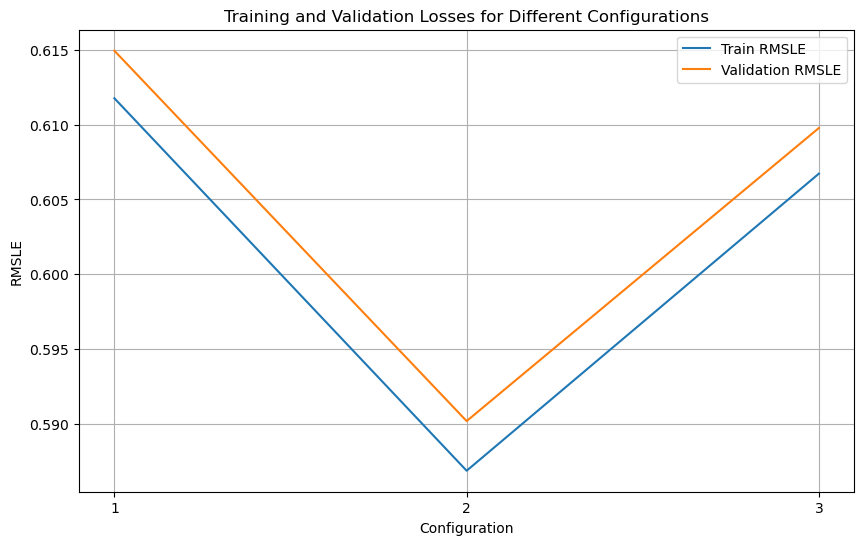

Benchmark Score (RMSLE): 0.513
Model 1 Test RMSLE: 0.6149549760875346
Model 2 Test RMSLE: 0.5901739055494084
Model 3 Test RMSLE: 0.6097857624830647


In [6]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt

# Model Selection
# Experiment with different configurations of the MLPRegressor
configurations = [
    {'hidden_layer_sizes': (64,), 'activation': 'relu'},
    {'hidden_layer_sizes': (128,), 'activation': 'relu'},
    {'hidden_layer_sizes': (64, 64), 'activation': 'relu'}
]

train_losses = []
val_losses = []

for config in configurations:
    # Create MLPRegressor model
    model = MLPRegressor(hidden_layer_sizes=config['hidden_layer_sizes'], activation=config['activation'],
                         max_iter=100, early_stopping=True, random_state=42)

    # Train the model
    model.fit(X_train_processed, y_train)

    # Predict on training and validation sets
    train_preds = model.predict(X_train_processed)
    val_preds = model.predict(X_test_processed)

    # Calculate RMSLE on training and validation sets
    train_loss = np.sqrt(mean_squared_log_error(y_train, train_preds))
    val_loss = np.sqrt(mean_squared_log_error(y_test, val_preds))

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Configuration: {config}, Train RMSLE: {train_loss}, Validation RMSLE: {val_loss}")

# Plot training and validation losses for each configuration
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train RMSLE')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation RMSLE')
plt.title('Training and Validation Losses for Different Configurations')
plt.xlabel('Configuration')
plt.ylabel('RMSLE')
plt.xticks(range(1, len(train_losses) + 1))
plt.legend()
plt.grid(True)
plt.show()

# Benchmark Comparison
# Benchmark score
benchmark_score = 0.513

# Print the benchmark score
print(f"Benchmark Score (RMSLE): {benchmark_score}")

# Evaluate each trained model on the test set
for i, config in enumerate(configurations):
    model = MLPRegressor(hidden_layer_sizes=config['hidden_layer_sizes'], activation=config['activation'],
                         max_iter=100, early_stopping=True, random_state=42)
    model.fit(X_train_processed, y_train)
    test_preds = model.predict(X_test_processed)
    test_loss = np.sqrt(mean_squared_log_error(y_test, test_preds))
    print(f"Model {i+1} Test RMSLE: {test_loss}")



Configuration: {'hidden_layer_sizes': (32,), 'activation': 'relu', 'alpha': 0.001}, Train RMSLE: 0.6022199602844289, Validation RMSLE: 0.6054434897258304
Configuration: {'hidden_layer_sizes': (64,), 'activation': 'relu', 'alpha': 0.001}, Train RMSLE: 0.6110985765033579, Validation RMSLE: 0.6142778435794698
Configuration: {'hidden_layer_sizes': (32, 32), 'activation': 'relu', 'alpha': 0.001}, Train RMSLE: 0.596157949928696, Validation RMSLE: 0.5994471381304937


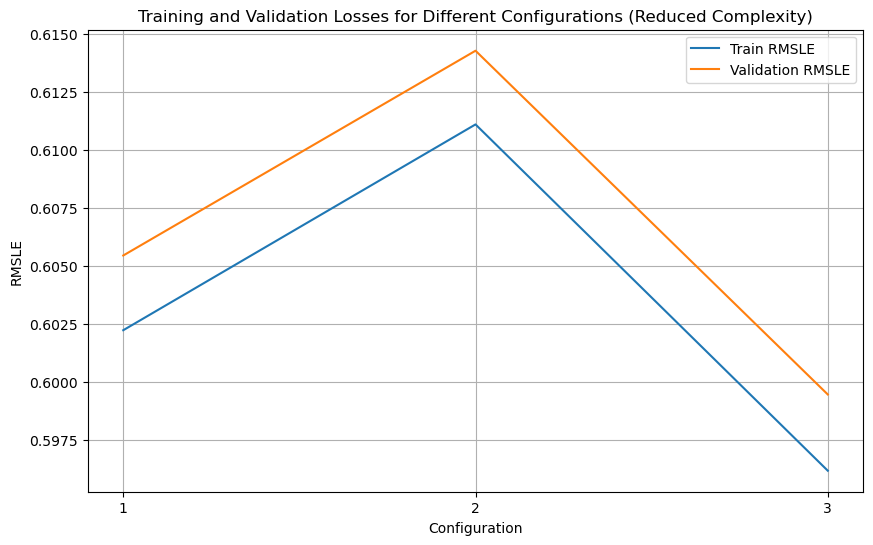

Benchmark Score (RMSLE): 0.513
Model 1 Test RMSLE: 0.6054434897258304
Model 2 Test RMSLE: 0.6142778435794698
Model 3 Test RMSLE: 0.5994471381304937


In [12]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt

# Model Selection with Reduced Complexity
configurations = [
    {'hidden_layer_sizes': (32,), 'activation': 'relu', 'alpha': 0.001},  # Reduced complexity
    {'hidden_layer_sizes': (64,), 'activation': 'relu', 'alpha': 0.001},  # Reduced complexity
    {'hidden_layer_sizes': (32, 32), 'activation': 'relu', 'alpha': 0.001}  # Reduced complexity
]

train_losses = []
val_losses = []

for config in configurations:
    model = MLPRegressor(hidden_layer_sizes=config['hidden_layer_sizes'], activation=config['activation'],
                         alpha=config['alpha'], max_iter=100, early_stopping=True, random_state=42,
                         solver='adam', learning_rate='adaptive', learning_rate_init=0.001,
                         beta_1=0.9, beta_2=0.999, epsilon=1e-8, tol=1e-4, verbose=False, shuffle=True,
                         validation_fraction=0.1, batch_size='auto')

    model.fit(X_train_processed, y_train)

    train_preds = model.predict(X_train_processed)
    val_preds = model.predict(X_test_processed)

    train_loss = np.sqrt(mean_squared_log_error(y_train, train_preds))
    val_loss = np.sqrt(mean_squared_log_error(y_test, val_preds))

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Configuration: {config}, Train RMSLE: {train_loss}, Validation RMSLE: {val_loss}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train RMSLE')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation RMSLE')
plt.title('Training and Validation Losses for Different Configurations (Reduced Complexity)')
plt.xlabel('Configuration')
plt.ylabel('RMSLE')
plt.xticks(range(1, len(train_losses) + 1))
plt.legend()
plt.grid(True)
plt.show()

# Benchmark Comparison (Unchanged)
benchmark_score = 0.513
print(f"Benchmark Score (RMSLE): {benchmark_score}")

for i, config in enumerate(configurations):
    model = MLPRegressor(hidden_layer_sizes=config['hidden_layer_sizes'], activation=config['activation'],
                         alpha=config['alpha'], max_iter=100, early_stopping=True, random_state=42,
                         solver='adam', learning_rate='adaptive', learning_rate_init=0.001,
                         beta_1=0.9, beta_2=0.999, epsilon=1e-8, tol=1e-4, verbose=False, shuffle=True,
                         validation_fraction=0.1, batch_size='auto')
    model.fit(X_train_processed, y_train)
    test_preds = model.predict(X_test_processed)
    test_loss = np.sqrt(mean_squared_log_error(y_test, test_preds))
    print(f"Model {i+1} Test RMSLE: {test_loss}")


Configuration: {'hidden_layer_sizes': (16,), 'activation': 'relu', 'alpha': 0.001}, Train RMSLE: 0.6085008522979334, Validation RMSLE: 0.6116849183892439
Configuration: {'hidden_layer_sizes': (32,), 'activation': 'relu', 'alpha': 0.001}, Train RMSLE: 0.6022199602844289, Validation RMSLE: 0.6054434897258304
Configuration: {'hidden_layer_sizes': (16, 16), 'activation': 'relu', 'alpha': 0.001}, Train RMSLE: 0.6263077977435522, Validation RMSLE: 0.6294626693766654


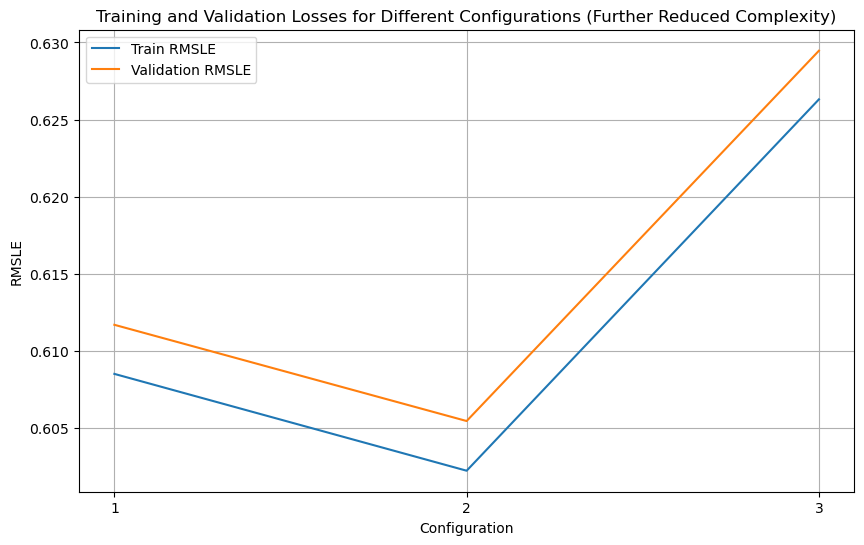

Benchmark Score (RMSLE): 0.513
Model 1 Test RMSLE: 0.6116849183892439
Model 2 Test RMSLE: 0.6054434897258304
Model 3 Test RMSLE: 0.6294626693766654


In [13]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt

# Model Selection with Further Reduced Complexity
configurations = [
    {'hidden_layer_sizes': (16,), 'activation': 'relu', 'alpha': 0.001},  # Further reduced complexity
    {'hidden_layer_sizes': (32,), 'activation': 'relu', 'alpha': 0.001},  # Further reduced complexity
    {'hidden_layer_sizes': (16, 16), 'activation': 'relu', 'alpha': 0.001}  # Further reduced complexity
]

train_losses = []
val_losses = []

for config in configurations:
    model = MLPRegressor(hidden_layer_sizes=config['hidden_layer_sizes'], activation=config['activation'],
                         alpha=config['alpha'], max_iter=100, early_stopping=True, random_state=42,
                         solver='adam', learning_rate='adaptive', learning_rate_init=0.001,
                         beta_1=0.9, beta_2=0.999, epsilon=1e-8, tol=1e-4, verbose=False, shuffle=True,
                         validation_fraction=0.1, batch_size='auto')

    model.fit(X_train_processed, y_train)

    train_preds = model.predict(X_train_processed)
    val_preds = model.predict(X_test_processed)

    train_loss = np.sqrt(mean_squared_log_error(y_train, train_preds))
    val_loss = np.sqrt(mean_squared_log_error(y_test, val_preds))

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Configuration: {config}, Train RMSLE: {train_loss}, Validation RMSLE: {val_loss}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train RMSLE')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation RMSLE')
plt.title('Training and Validation Losses for Different Configurations (Further Reduced Complexity)')
plt.xlabel('Configuration')
plt.ylabel('RMSLE')
plt.xticks(range(1, len(train_losses) + 1))
plt.legend()
plt.grid(True)
plt.show()

# Benchmark Comparison (Unchanged)
benchmark_score = 0.513
print(f"Benchmark Score (RMSLE): {benchmark_score}")

for i, config in enumerate(configurations):
    model = MLPRegressor(hidden_layer_sizes=config['hidden_layer_sizes'], activation=config['activation'],
                         alpha=config['alpha'], max_iter=100, early_stopping=True, random_state=42,
                         solver='adam', learning_rate='adaptive', learning_rate_init=0.001,
                         beta_1=0.9, beta_2=0.999, epsilon=1e-8, tol=1e-4, verbose=False, shuffle=True,
                         validation_fraction=0.1, batch_size='auto')
    model.fit(X_train_processed, y_train)
    test_preds = model.predict(X_test_processed)
    test_loss = np.sqrt(mean_squared_log_error(y_test, test_preds))
    print(f"Model {i+1} Test RMSLE: {test_loss}")


Configuration: {'hidden_layer_sizes': (8,), 'activation': 'relu', 'alpha': 0.001}, Train RMSLE: 0.607967868576779, Validation RMSLE: 0.6111739276983055
Configuration: {'hidden_layer_sizes': (16,), 'activation': 'relu', 'alpha': 0.001}, Train RMSLE: 0.6085008522979334, Validation RMSLE: 0.6116849183892439
Configuration: {'hidden_layer_sizes': (8, 8), 'activation': 'relu', 'alpha': 0.001}, Train RMSLE: 0.5892983933760103, Validation RMSLE: 0.5925997373297336


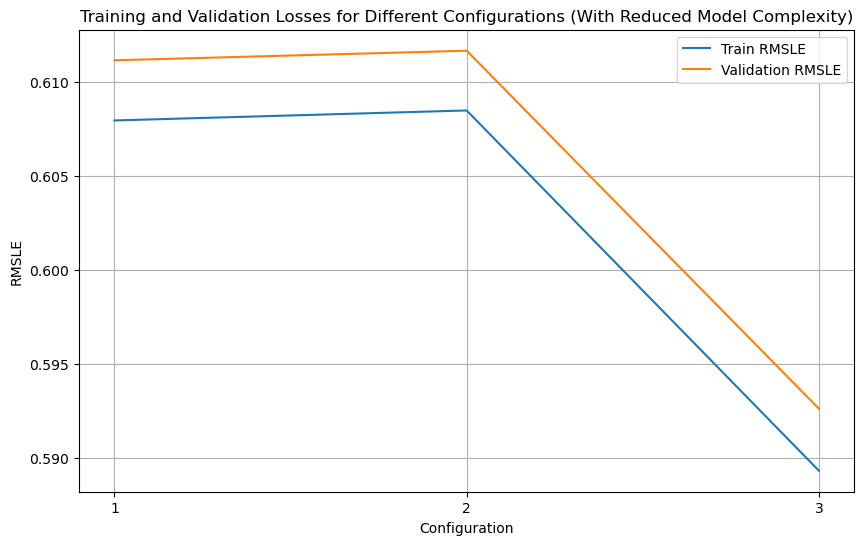

Benchmark Score (RMSLE): 0.513
Model 1 Test RMSLE: 0.6111739276983055
Model 2 Test RMSLE: 0.6116849183892439
Model 3 Test RMSLE: 0.5925997373297336
